# Detecting and Classifying Skin Cancers With CNN Model

### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [34]:
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import f1_score

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD

from imblearn.over_sampling import SMOTE

### Define Paths and Training Data

In [17]:
# Create paths for our cropped images
os.chdir('/content/drive/MyDrive/Skin_Lesion_Project')
dirpath = os.getcwd()
cropped_PATH = os.path.join(dirpath, 'Data Cleaning and Pre-Processing/Cropped_Images')
cropped_ak = os.path.join(cropped_PATH, 'actinic keratosis')
cropped_bcc = os.path.join(cropped_PATH, 'basal cell carcinoma')
cropped_derm = os.path.join(cropped_PATH, 'dermatofibroma')
cropped_mel = os.path.join(cropped_PATH, 'melanoma')
cropped_nev = os.path.join(cropped_PATH, 'melanocytic nevi')
cropped_bkl = os.path.join(cropped_PATH, 'benign keratosis')
cropped_vl = os.path.join(cropped_PATH, 'vascular lesion')

cropped_files_ak = os.listdir(cropped_ak)
cropped_files_bcc = os.listdir(cropped_bcc)
cropped_files_derm = os.listdir(cropped_derm)
cropped_files_mel = os.listdir(cropped_mel)
cropped_files_nev = os.listdir(cropped_nev)
cropped_files_pbk = os.listdir(cropped_bkl)
cropped_files_vl = os.listdir(cropped_vl)

cropped_paths_ak = [os.path.join(cropped_ak, file) for file in cropped_files_ak]
cropped_paths_bcc = [os.path.join(cropped_bcc, file) for file in cropped_files_bcc]
cropped_paths_derm = [os.path.join(cropped_derm, file) for file in cropped_files_derm]
cropped_paths_mel = [os.path.join(cropped_mel, file) for file in cropped_files_mel]
cropped_paths_nev = [os.path.join(cropped_nev, file) for file in cropped_files_nev]
cropped_paths_bkl = [os.path.join(cropped_bkl, file) for file in cropped_files_pbk]
cropped_paths_val = [os.path.join(cropped_vl, file) for file in cropped_files_vl]

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'benign keratosis', 'vascular lesion']

# Create a dataframes of our cropped images and their label
df_ak = pd.DataFrame({'image': cropped_paths_ak, 'label': class_names[0]})
df_bcc = pd.DataFrame({'image': cropped_paths_bcc, 'label': class_names[1]})
df_derm = pd.DataFrame({'image': cropped_paths_derm, 'label': class_names[2]})
df_mel = pd.DataFrame({'image': cropped_paths_mel, 'label': class_names[3]})
df_nev = pd.DataFrame({'image': cropped_paths_nev, 'label': class_names[4]})
df_bkl = pd.DataFrame({'image': cropped_paths_bkl, 'label': class_names[5]})
df_vl = pd.DataFrame({'image': cropped_paths_val, 'label': class_names[6]})

# Combine dataframe of image paths and their label to train
train_data = pd.concat([df_ak, df_bcc, df_derm, df_mel, df_nev, df_bkl, df_vl])

print("Training data has been created!")

Training data has been created!


## Cancer Detection With Convolutional Connected Network (CNN)
#### Create train and validation data from our cropped images for our CNN

In [19]:
df_train, df_test = train_test_split(train_data,
                                     test_size=.2,
                                     stratify=train_data.label,
                                     shuffle=True,
                                     random_state=41)
df_train, df_val = train_test_split(df_train,
                                    test_size=.1,
                                    stratify=df_train.label,
                                    shuffle=True,
                                    random_state=41)

In [20]:
# Set image size and batch size for training
image_size = (256, 256)
batch_size = 32

# Create an ImageDataGenerator Object for preprocessing
datagen = ImageDataGenerator(
)

# Create train_batches using flow_from_directory
train_batches = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes= class_names,
    shuffle = True
)

# Create test_batches using flow_from_directory
test_batches = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

val_batches = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

Found 7210 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 802 validated image filenames belonging to 7 classes.


### Define the Architecture of our CNN Model

In [21]:
from tensorflow.keras import backend as K

# Clearing previous models from memory
K.clear_session()

# Intialize a sequential model
model_cnn=keras.models.Sequential()

# Add first convolution layer of 32 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(256,256, 3)))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

# Add second convolution layer of 64 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Add third convolution layer of 128 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a thrid max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Flatten output from previous layers
model_cnn.add(keras.layers.Flatten())

# Add a fully connected dense layer of 1024 neurons
model_cnn.add(keras.layers.Dense(1024,activation='relu'))

# Add dropout layer (30% of neurons will be randomly turned off to prevent overfitting)
model_cnn.add(keras.layers.Dropout(0.3))

# Add output layer of 9 neuros (one for each class)
model_cnn.add(keras.layers.Dense(7,activation='softmax'))

# Display model architecture
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,198,599 (8.39 MB)

 Trainable params: 2,198,599 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

### Define Handy Callback Function

In [22]:
# Folder name to save our model
model_folder = 'model_cnn'
# Path to save our CNN model to
checkpoint_file = os.path.join(dirpath, model_folder, 'checkpoint.model.keras')
# Saves the model only if its performance improves
checkpoint_cb = ModelCheckpoint(checkpoint_file, save_best_only=True)
# Stop early if model's performance doesn't imporve for 5 epochs
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
# Model compilation
model_cnn.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
# Train our model
hist=model_cnn.fit(train_batches,
               validation_data = val_batches,
               validation_split=.1,
               epochs=50,
               callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 165s 717ms/step - accuracy: 0.6242 - auc: 0.8668 - loss: 5.6012 - specificity_at_sensitivity: 0.9614 - val_accuracy: 0.6783 - val_auc: 0.9351 - val_loss: 0.9134 - val_specificity_at_sensitivity: 0.9886
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 199s 705ms/step - accuracy: 0.6814 - auc: 0.9328 - loss: 0.8915 - specificity_at_sensitivity: 0.9858 - val_accuracy: 0.6796 - val_auc: 0.9332 - val_loss: 0.9083 - val_specificity_at_sensitivity: 0.9877
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 206s 723ms/step - accuracy: 0.6806 - auc: 0.9321 - loss: 0.8940 - specificity_at_sensitivity: 0.9858 - val_accuracy: 0.6733 - val_auc: 0.9342 - val_loss: 0.8944 - val_specificity_at_sensitivity: 0.9859
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 164s 719ms/step - accuracy: 0.6808 - auc: 0.9331 - loss: 0.8849 - specificity_at_sensitivity: 0.9873 - val_accuracy: 0.6945 - val_auc: 0.9443 - val_loss: 0.8229 - val_specificity_at_sensitivity: 0.9892
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 196

### Outputting Results of Model

In [27]:
# Create a dataframe of our training session and store it in google drive
hist_cnn=pd.DataFrame(hist.history)
hist_cnn.to_csv('/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/cnn_output.csv', index=False)
hist_cnn

,accuracy,auc,loss,specificity_at_sensitivity,val_accuracy,val_auc,val_loss,val_specificity_at_sensitivity
0,0.651872,0.906156,1.969675,0.978618,0.678304,0.935130,0.913355,0.988570
1,0.680305,0.930456,0.906276,0.985183,0.679551,0.933208,0.908279,0.987739
2,0.680860,0.932649,0.893162,0.986685,0.673317,0.934237,0.894393,0.985869
3,0.684743,0.936111,0.867766,0.987540,0.694514,0.944304,0.822871,0.989194
4,0.694175,0.940985,0.836112,0.988673,0.652120,0.925584,0.954472,0.985453
5,0.695978,0.941538,0.831629,0.989228,0.680798,0.942001,0.838009,0.989609
6,0.702358,0.943612,0.815678,0.989274,0.695761,0.943077,0.843771,0.988986
7,0.706103,0.946173,0.796312,0.990430,0.689526,0.941875,0.852449,0.990025
8,0.714979,0.949433,0.772462,0.990638,0.711970,0.947958,0.798204,0.990648
9,0.712205,0.949401,0.773170,0.990730,0.701995,0.944872,0.809705,0.991895


### Plot training and validation accuracy to assess model training

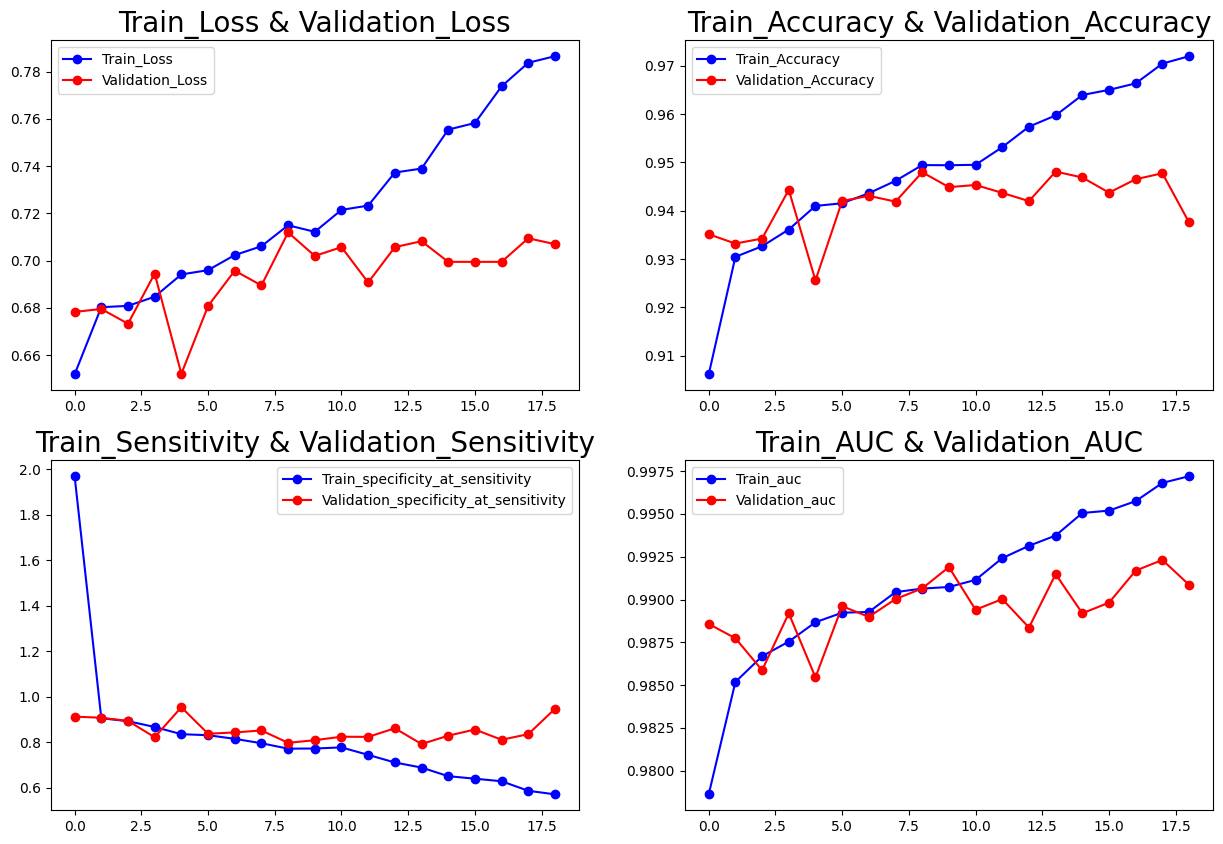

In [28]:
# Create plot of Train Loss and Validation Loss
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_cnn.iloc[:,0],'b-o',label='Train_Loss')
plt.plot(hist_cnn.iloc[:,4],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
# Create plot of Train Accuracy and Validation Accuracy
plt.subplot(2,2,2)
plt.plot(hist_cnn.iloc[:,1],'b-o',label='Train_Accuracy')
plt.plot(hist_cnn.iloc[:,5],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Create plot of Train Sesitivity and Validation Sensitivity
plt.subplot(2,2,3)
plt.plot(hist_cnn.iloc[:,2],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_cnn.iloc[:,6],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
# Create plot of Train AUC and Validation AUC
plt.subplot(2,2,4)
plt.plot(hist_cnn.iloc[:,3],'b-o',label='Train_auc')
plt.plot(hist_cnn.iloc[:,7],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

### Model Evaluation

In [29]:
score, acc,sensitivity,auc = model_cnn.evaluate(train_batches)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

226/226 ━━━━━━━━━━━━━━━━━━━━ 93s 410ms/step - accuracy: 0.7861 - auc: 0.9708 - loss: 0.6092 - specificity_at_sensitivity: 0.9973
Test Loss = 0.6050049662590027
Test Accuracy = 0.7877947092056274
Test Sensitivity = 0.9973416328430176
Test AUC = 0.9713024497032166


#### F1 score

In [31]:
# Make predictions on the validation set
predictions = model_cnn.predict(test_batches, len(test_batches), verbose = 1)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_batches.classes  # Convert true labels if in categorical format

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1 Score: {f1:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 435ms/step
F1 Score: 0.7092


### Predicting Test Data with our Model

In [33]:
predictions = model_cnn.predict(test_batches, len(test_batches), verbose = 1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_batches.classes
y_test = np.ravel(true_labels)
y_pred = np.ravel(predicted_labels)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step


,Actual,Prediction
0,4,4
1,4,4
2,4,4
3,4,4
4,4,4
...,...,...
1998,5,4
1999,1,4
2000,4,4
2001,4,4


### Confusion Matrix of CNN Model

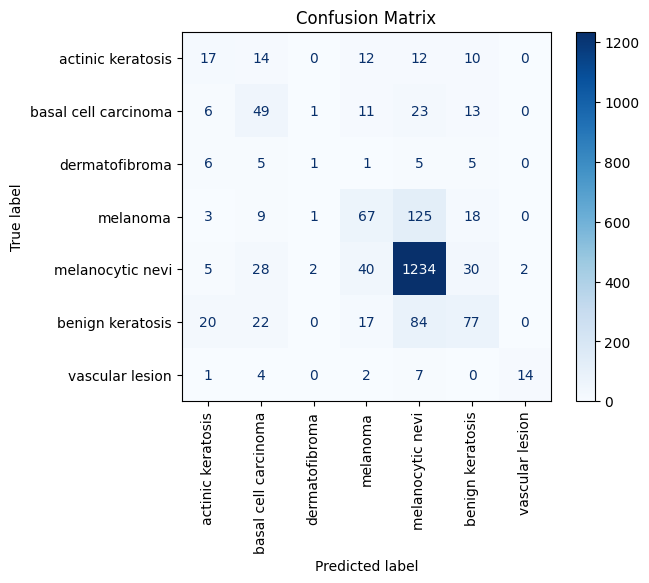

In [40]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)

# Show the plot
plt.show()

## Zip Model Folders and Transfer Files to Google Drive

In [42]:
# Create a zip file of our CNN model
!zip -r model_cnn.zip model_cnn

  adding: model_cnn/ (stored 0%)
  adding: model_cnn/checkpoint.model.keras (deflated 13%)


In [44]:
# Transfer all files to our google drive folder
!sudo cp -v -r "/content/drive/MyDrive/Skin_Lesion_Project/model_cnn/" "/content/drive/MyDrive/Skin_Lesion_Project/CNN Model"
!sudo cp -v -r "/content/drive/MyDrive/Skin_Lesion_Project/model_cnn.zip" "/content/drive/MyDrive/Skin_Lesion_Project/CNN Model"


'/content/drive/MyDrive/Skin_Lesion_Project/model_cnn/' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn'
'/content/drive/MyDrive/Skin_Lesion_Project/model_cnn/checkpoint.model.keras' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn/checkpoint.model.keras'
'/content/drive/MyDrive/Skin_Lesion_Project/model_cnn.zip' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn.zip'
